### Удаление плохих триалов из данных
Основная идея: eeg  стационарный процесс в слабом смысле, считаем что отсчеты распределены "нормально" и если есть большие выбросы - то это идет откуда-то снаружи. Также трендов не должно быть

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [4]:
filename = 'DATA/EEG_MentalInfo.pickle'
with open(filename, 'rb') as f:
    EEG_info = pickle.load(f)
Im_names = EEG_info['list_Im']
Mem_names = EEG_info['list_Mem']
Sl_names = EEG_info['list_Sl'] 
Empty_names = EEG_info['list_Empty']
EmptySl_names = EEG_info['list_Empty']

In [5]:
import os.path
import sys
home = str(os.path.expanduser("~"))
path_to_class = os.path.join(home,'PycharmProjects/EEGAnalyser/')
sys.path.append(path_to_class)
from EEGProcessing import EEGAnalyser

In [73]:
def path_define(name):
    sig_number = 'D0000'+str(name)
    sigName = 'DATA/CSV/'+ sig_number +'.csv'
    timingName = 'DATA/timing/'+sig_number+'.TXT'
    failedTrialsName = 'DATA/failed_trials/'+sig_number+'.txt'
    failedTrialsSave = 'DATA/failed_trials/'+sig_number+'Corr.txt'
    return sigName, timingName, failedTrialsName, failedTrialsSave

In [6]:
myExperiment = EEGAnalyser(srate = 500,min_freq = 4, max_freq=30, num_freq=10)
myExperiment.min_length = 3480

In [49]:
def check_failed_trial(data_ch, trial_len = 3480):
    """
    check failed trials
    input: numpy 1d array
    
    """
    f_tr = []
    f_trOut = []
    f_trTrend = []
    
    #check trials with big outliers
    

    if np.std(data_ch) > 3*np.percentile(data_ch,70):
        #print('Find outliers', np.std(data_ch),np.percentile(data_ch,70))
        f_trOut= np.unique(np.where(abs(data_ch)>3*np.std(data_ch))[0]//trial_len)
          
    
    #check trials with trend
    Ntrials = data_ch.shape[0]//trial_len
    mean_trial = np.zeros(Ntrials)
    for k in range(Ntrials):
        mean_trial[k]= np.mean(data_ch[k*trial_len:(k+1)*trial_len])
    perc_70 = np.percentile(np.abs(mean_trial),70)
    if np.std(mean_trial)>3*perc_70:
        #print(np.std(mean_trial),perc_70)
        f_thresh = 3*perc_70 
        f_trTrend = np.where(np.abs(mean_trial) > f_thresh)[0]
        #print(f_trTrend)
    f_tr = list(set(f_trOut).union(set(f_trTrend))) 
 
              
    return f_tr, mean_trial 

def drop_failed(data_ch, f_tr, trial_len =  3480):
    if len(f_tr)>0:
        nTrials = data_ch.shape[0]//trial_len
        data_r = np.reshape(data_ch, [trial_len, nTrials], order="F")
        data_crop = np.delete(data_r, f_tr, axis=1)
        data_crop = data_crop.flatten('F')
    else:
        data_crop = data_ch
    return data_crop

def check_all_channel(data, trial_len = 3480):
    f_tr = set()
    for i in range(19):
        f_trSingle, _ = check_failed_trial(data.iloc[:,i].values)
        f_tr = f_tr.union(set(f_trSingle))
    return list(f_tr) 

In [74]:
name = Empty_names[5]
sigName, timingName, failedTrialsName, failedTrialsSave = path_define(name)
print(sigName)
data = myExperiment.load_data(sigName, timingName, failedTrialsName)
label_list = np.unique(data['LABEL'])
data = myExperiment.normalize_data()

DATA/CSV/D0000452.csv


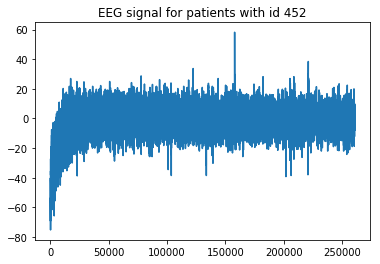

In [51]:
data.iloc[:,7].plot(); plt.title('EEG signal for patients with id {}'.format(name));

Text(0.5,1,'Modified data')

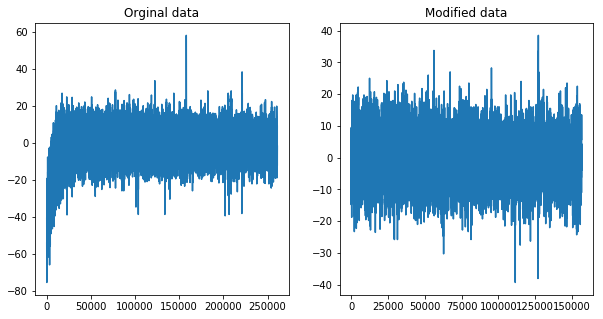

In [60]:
k=7
data_ch= data.iloc[:,k].values
f_tr = check_all_channel(data, trial_len = 3480)
data_crop = drop_failed(data_ch,f_tr)

plt.figure(figsize = (10,5))
plt.subplot(1,2,1); plt.plot(data_ch); plt.title('Orginal data')
data_crop = drop_failed(data_ch, f_tr)
plt.subplot(1,2,2); plt.plot(data_crop); plt.title('Modified data')

In [88]:
with open(failedTrialsSave, 'w') as f:
    f_trOld =np.loadtxt(failedTrialsName).astype(int)
    f_trNew = label_list[f_tr]
    f_trAll = np.sort(np.concatenate([f_trOld, f_trS]))
    np.savetxt(f, f_trAll, fmt = '%d')

In [83]:
#проверим, что все записалось
data = myExperiment.load_data(sigName, timingName, failedTrialsSave)
data = myExperiment.normalize_data()

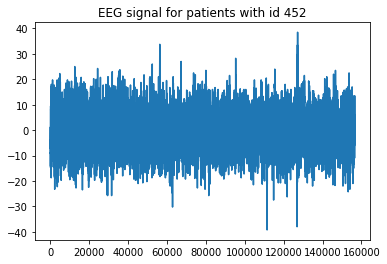

In [84]:
data.iloc[:,7].plot(); plt.title('EEG signal for patients with id {}'.format(name));

In [90]:
### Перезапишем все данные
import glob
file_list = glob.glob("DATA/CSV/*.csv")

In [109]:
numbers = [os.path.basename(file)[5:8] for file in file_list]
for number in numbers[1:]:

    sigName, timingName, failedTrialsName, failedTrialsSave = path_define(number)
    #if os.path.isfile(failedTrialsSave):
    #    print('File already exist', failedTrialsSave )
    #    continue
    print('Process file: ', sigName)
    data = myExperiment.load_data(sigName, timingName, failedTrialsName)
    label_list = np.unique(data['LABEL'])
    data = myExperiment.normalize_data()
    f_tr = check_all_channel(data, trial_len = 3480)
    with open(failedTrialsSave, 'w') as f:
        f_trOld =np.loadtxt(failedTrialsName).astype(int)
        f_trNew = label_list[f_tr]
        f_trAll = np.sort(np.concatenate([f_trOld, f_trNew]))
        np.savetxt(f, f_trAll, fmt = '%d')
        print('Saved updated failed trials to', failedTrialsSave)

Process file:  DATA/CSV/D0000484.csv
Saved updated failed trials to DATA/failed_trials/D0000484Corr.txt
Process file:  DATA/CSV/D0000452.csv
Saved updated failed trials to DATA/failed_trials/D0000452Corr.txt
Process file:  DATA/CSV/D0000446.csv
Saved updated failed trials to DATA/failed_trials/D0000446Corr.txt
Process file:  DATA/CSV/D0000526.csv
Saved updated failed trials to DATA/failed_trials/D0000526Corr.txt
Process file:  DATA/CSV/D0000530.csv
Saved updated failed trials to DATA/failed_trials/D0000530Corr.txt
Process file:  DATA/CSV/D0000487.csv
Saved updated failed trials to DATA/failed_trials/D0000487Corr.txt
Process file:  DATA/CSV/D0000450.csv
Saved updated failed trials to DATA/failed_trials/D0000450Corr.txt
Process file:  DATA/CSV/D0000444.csv
Saved updated failed trials to DATA/failed_trials/D0000444Corr.txt
Process file:  DATA/CSV/D0000478.csv
Saved updated failed trials to DATA/failed_trials/D0000478Corr.txt
Process file:  DATA/CSV/D0000445.csv
Saved updated failed trials

In [105]:
number = '413'
sigName, timingName, failedTrialsName, failedTrialsSave = path_define(number)
data = myExperiment.load_data(sigName, timingName, failedTrialsName)

In [106]:
label_list = np.unique(data['LABEL'])

In [107]:
label_list

array([11, 14, 16, 17, 20, 21, 22, 24, 26, 29, 30, 32, 33, 34, 37, 38, 39,
       40, 46, 48, 49, 50, 51, 52, 53, 56, 57, 58, 62, 63, 65, 66, 67])